# Forensic Reconstruction of Severely Degraded License Plates

In [2]:
%matplotlib notebook
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from ipywidgets import interact, IntSlider, Layout
from utils import visualize_predictions
from model import LicensePlatesCNN
from skimage import img_as_float
from imageio import imread
import tensorflow as tf
from glob import glob
import numpy as np
import string
import h5py
import re


# Insert path to trained weights here
checkpoint_dir = "../model/checkpoint"
summary_dir = "../model/summary"

# Path to test images
test_files = sorted(glob("../imgs/*.png"), reverse=True)

# Set up font
font = {'family' : 'monospace',
        'weight' : 'bold',
        'size'   : 11}

rc('font', **font)
rc('text', usetex=True)
params = {'text.latex.preamble': [r"\usepackage{amsmath}", r"\usepackage{bm}"]}
plt.rcParams.update(params)

Initialize network and load trained weights.

In [3]:

sess = tf.compat.v1.InteractiveSession()
cnn = LicensePlatesCNN(sess, checkpoint_dir, summary_dir)
cnn.load();

W0421 16:31:22.131415 140339185469248 deprecation.py:506] From /home/clizia/anaconda3/envs/Lorch/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1635: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W0421 16:31:22.151118 140339185469248 deprecation.py:323] From /home/clizia/license-plates/src/model.py:171: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0421 16:31:22.153689 140339185469248 deprecation.py:323] From /home/clizia/anaconda3/envs/Lorch/lib/python3.7/site-packages/tensorflow_core/python/layers/pooling.py:311: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instr

2021-04-21 16:31:22,357 - LicensePlatesCNN - DEBUG - Attempting to read checkpoint from ../model/checkpoint


I0421 16:31:22.357596 140339185469248 model.py:336] Attempting to read checkpoint from ../model/checkpoint


2021-04-21 16:31:22,549 - LicensePlatesCNN - INFO - Successfully restored checkpoint


I0421 16:31:22.549191 140339185469248 model.py:341] Successfully restored checkpoint


Run inference and visualize predictions.

<IPython.core.display.Javascript object>


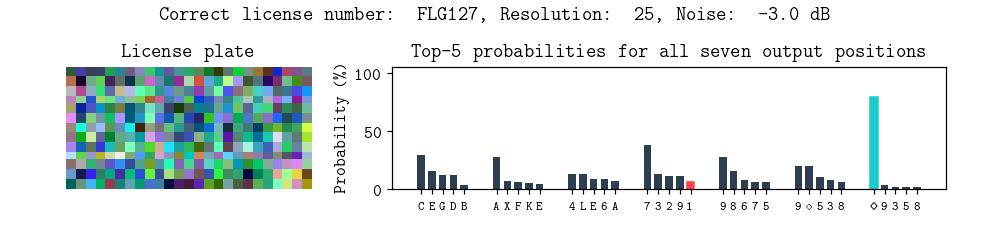

interactive(children=(IntSlider(value=0, continuous_update=False, description='Sample', layout=Layout(width='1…

In [4]:
fig = plt.figure(figsize=(9, 2.2))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
img_ax = plt.subplot(gs[0, 0])
img_ax.set_title("License plate")
img_ax.axis("off")
prob_ax = plt.subplot(gs[0, 1])
prob_ax.set_title("Top-5 probabilities for all seven output positions")
fig.tight_layout(rect=[0, 0.03, 1, 0.90])

def display_result(test_file_idx):
    test_filename = test_files[test_file_idx]
    # Load and display image
    img = img_as_float(imread(test_filename))
    img_ax.imshow(img)
    
    char_labels = None
    suptitle = ""
    # Extract license number, resolution, and noise level from filename
    match = re.search("license_number_([A-Z0-9]+)_resolution_([0-9]+)_noise_SNR_db_([-+]?[0-9]*\.?[0-9]+)", test_filename)
    if match is not None:
        license_number = match.group(1)
        resolution = int(match.group(2))
        noise_SNR_db = float(match.group(3))
        suptitle = "Correct license number: {}, Resolution: {:d}, Noise: {:2.1f} dB".format(license_number, resolution, noise_SNR_db)

        # Convert license number extracted from filename to one-hot encoded label vector
        char_labels = np.zeros((7, 37))
        all_chars = string.ascii_uppercase + string.digits + "_"
        # One-hot encode characters
        for i in range(len(license_number)):
            char_labels[i, all_chars.index(license_number[i])] = 1
        # For the remaining positions set the `no char` label
        for i in range(len(license_number), 7):
            char_labels[i, 36] = 1
    
    # Feed batch containing the single image to network
    char_predictions = cnn.inference(img[None, :])[0]
    # Visualize predictions
    visualize_predictions(prob_ax, char_predictions, char_labels)
    # Set figure title
    fig.suptitle(suptitle)

interact(display_result, test_file_idx=IntSlider(min=0, max=len(test_files) - 1, continuous_update=False, description="Sample", layout=Layout(width="100%")));

## Instructions

* Use slider to select sample from data directory.